tensor([0.2699, 0.8025, 0.0322, 0.0600, 0.1370], requires_grad=True) tensor([0.7101, 0.8350, 0.9327, 0.0665, 0.7194], requires_grad=True)
Epoch 0, -log10(Loss): -0.6477, Params: [[0.39070457]
 [0.07603747]], t_c: [0.25986505 0.8124937  0.02216517 0.05004334 0.12697665], Jump size: [0.7001358  0.8249601  0.9227438  0.05647545 0.70937127]
Epoch 5, -log10(Loss): -0.0804, Params: [[0.34166998]
 [0.11879352]], t_c: [0.21272172 0.86189497 0.         0.00781861 0.08022162], Jump size: [0.65464383 0.778741   0.87783766 0.01133254 0.6639494 ]
Epoch 10, -log10(Loss): 0.2391, Params: [[0.2917345 ]
 [0.14976609]], t_c: [0.17061695 0.9133095  0.         0.         0.03985455], Jump size: [0.6176497  0.73982704 0.8414207  0.         0.6274977 ]
Epoch 15, -log10(Loss): 0.4976, Params: [[0.23847078]
 [0.1722059 ]], t_c: [0.13224891 0.9664299  0.         0.         0.00525449], Jump size: [0.58779573 0.7071586  0.81131107 0.         0.59882426]
Epoch 20, -log10(Loss): 0.7740, Params: [[0.1818799 ]
 [0.

KeyboardInterrupt: 

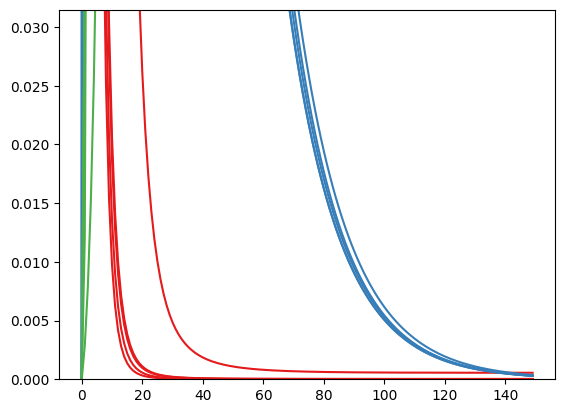

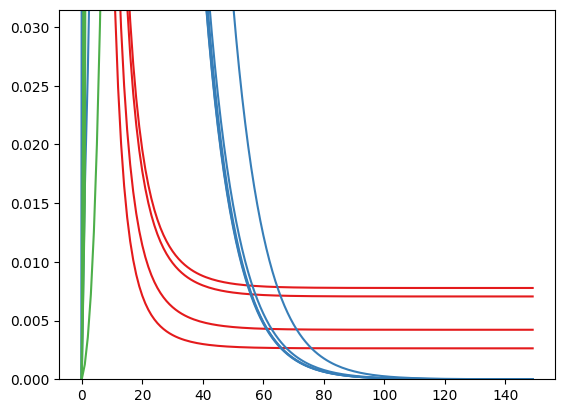

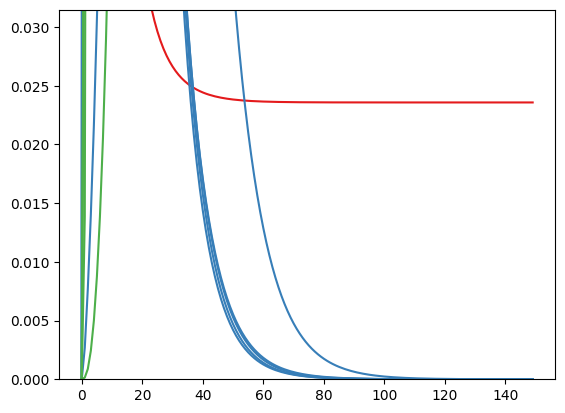

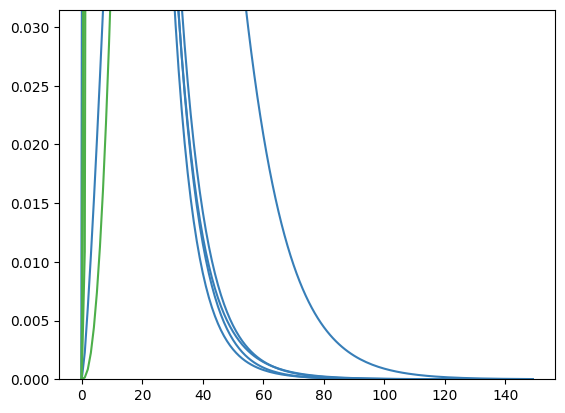

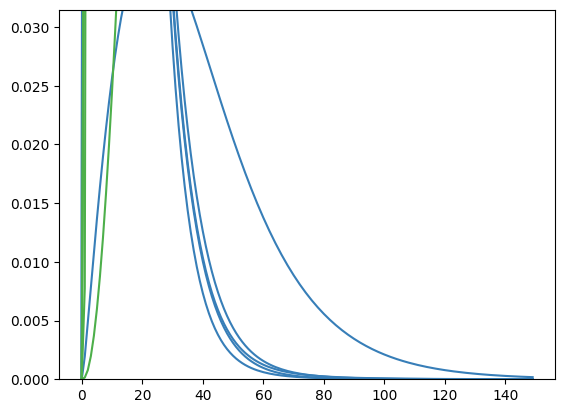

In [13]:
import torch
from torchdiffeq import odeint
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette('Set1')

cities_count = 5
big_size = 660000
small_size = 110000
flow_to_msk = 0.15
flow_to_obl = 0.03/4
flow_to_neighbour = 0.01
flow_to_corner = 0.002

flow_red = 0.1

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
adjacency_matrix = flow_red * np.array([[0, flow_to_obl, flow_to_obl, flow_to_obl, flow_to_obl],
                            [flow_to_msk, 0, flow_to_neighbour, flow_to_neighbour, flow_to_corner],
                            [flow_to_msk, flow_to_neighbour, 0, flow_to_corner, flow_to_neighbour],
                            [flow_to_msk, flow_to_neighbour, flow_to_corner, 0, flow_to_neighbour],
                            [flow_to_msk, flow_to_corner, flow_to_neighbour, flow_to_neighbour, 0]])


dt = np.load(f'pkls/diffsatellites_1_1.0_{flow_red}.npy', allow_pickle=True)[0,:,0,1:]
dt = (dt.T/pop_sizes).T



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def source(t, t_c, jump_size, k=10.0):
    exp_term = torch.exp(-k * (t - t_c))
    return jump_size * k * exp_term / (1 + exp_term)**2


def sir(t, y, params, t_c, jump_size, F, N = torch.ones(cities_count, device=device), k=10.0):
    S = y[0]
    I = y[1]
    R = y[2]
    beta = params[0]
    g = params[1]
    dS = - beta * S * I #- source(t, t_c, jump_size, k)
    dI = beta * S * I - g * I + source(t, t_c, jump_size, k) + ((N * I) @ F) / N
    dR = g * I
    
    return torch.stack([dS, dI, dR])


def solve_ode(params, t_c, jump_size, t, y0, F, N = torch.ones(cities_count, device=device), k=10.0):
    def ode_func(t, y):
        return sir(t, y, params, t_c, jump_size, F, N, k)
    return odeint(ode_func, y0, t, method='midpoint', options={'step_size': 0.1})




t = torch.arange(dt.shape[-1], device=device).float()
y0 = torch.from_numpy(np.array([[1]*cities_count, [0]*cities_count, [0]*cities_count])).to(device).float()
true_y = torch.from_numpy(dt).to(device).float()
F = torch.from_numpy(adjacency_matrix).to(device).float()
N = torch.from_numpy(pop_sizes).to(device).float()

# print(y0)

# params = torch.ones(2, cities_count, device=device, requires_grad=True).float()
params = torch.rand(2, 1, device=device, requires_grad=True).float()
# t_c = torch.full((cities_count,), dt.shape[-1]/2, device=device, requires_grad=True).float()
t_c = torch.rand(cities_count, device=device, requires_grad=True).float()
# jump_size = torch.full((cities_count,), np.max(dt)/100, device=device, requires_grad=True).float()
jump_size = torch.rand(cities_count, device=device, requires_grad=True).float()

print(t_c, jump_size)

optimizer = optim.Adam([params, t_c, jump_size], lr=1e-2)
# warmup_steps = 1000
# optimizer = torch.optim.AdamW([params, t_c, jump_size], lr=0.1, weight_decay=0.01)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda step: min(1.0, step / warmup_steps))

# optimizer = torch.optim.AdamW([params, t_c, jump_size], lr=0.001)
# scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=0.1, step_size_up=500, mode='triangular')

epsilon = 1e-16
n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad() 
    
    y_pred = solve_ode(params, t_c, jump_size, t, y0, F, N)

    loss = torch.mean((y_pred[:,1,:].T - true_y) ** 2) + torch.mean((torch.sum(y_pred[:,1,:].T, dim=1) - torch.sum(true_y, dim=1)) ** 2) / true_y.shape[1]
    
    loss.backward()
    
    optimizer.step()

    # scheduler.step()

    with torch.no_grad():
        t_c.clamp_(min=0.0, max=dt.shape[-1])
        # params.clamp_(min=0.0, max=1e-3)
        params.clamp_min_(min=0.0)
        # jump_size.clamp_(min=0.0, max=np.max(dt))
        jump_size.clamp_min_(min=0.0)
    
    if epoch % 5 == 0:
        y_pred_npy = y_pred.detach().cpu().numpy()
        fig, ax = plt.subplots()
        for i in range(y_pred_npy.shape[1]):
            # print(y_pred_npy.shape)
            ax.plot(y_pred_npy[:,i,:], color=colors[i])
            # ax.plot()
            # ax.set_xlim(0,20)
            ax.set_ylim(0,np.max(dt))

        print(f'Epoch {epoch}, -log10(Loss): {-np.log10(loss.item()):.4f}, Params: {params.detach().cpu().numpy()}, '
              f't_c: {t_c.detach().cpu().numpy()}, Jump size: {jump_size.detach().cpu().numpy()}')


print(f'Оптимизированные параметры: {params.detach().cpu().numpy()}')
print(f'Оптимизированный t_c: {t_c.detach().cpu().numpy()}')
print(f'Оптимизированная величина поступления: {jump_size.detach().cpu().numpy()}')

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.72727273e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.09090909e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.06060606e-06 9.09090909e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.51515152e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.72727273e-05 9.09090909e-06 5.45454545e-05
  0.00000000e+00]
 [4.54545455e-06 6.36363636e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.54545455e-06 3.63636364e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.54545455e-06 9.09090909e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.51515152e-06 3.63636364e-05 0.00000000e+00 9.09090909e-06
  0.00000000e+00]
 [1.21212121e-05 3.63636364e-05 0.00000000e+00 9.09090909e-06
  0.00000000e+00]
 [1.51515152e-06 3.63636364e-05 0.000000

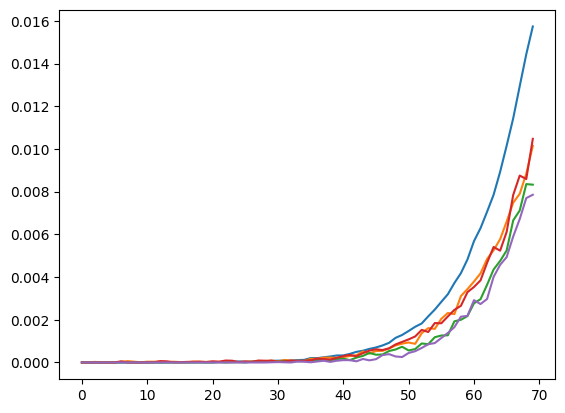

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch

cities_count = 5
big_size = 660000
small_size = 110000
flow_to_msk = 0.15
flow_to_obl = 0.03/4
flow_to_neighbour = 0.01
flow_to_corner = 0.002

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
adjacency_matrix = np.array([[0, flow_to_obl, flow_to_obl, flow_to_obl, flow_to_obl],
                            [flow_to_msk, 0, flow_to_neighbour, flow_to_neighbour, flow_to_corner],
                            [flow_to_msk, flow_to_neighbour, 0, flow_to_corner, flow_to_neighbour],
                            [flow_to_msk, flow_to_neighbour, flow_to_corner, 0, flow_to_neighbour],
                            [flow_to_msk, flow_to_corner, flow_to_neighbour, flow_to_neighbour, 0]])

dt = np.load('pkls/diffsatellites_1_1.0_1.0.npy', allow_pickle=True)[0,:,0,1:]
dt = (dt.T/pop_sizes)

plt.plot(dt[:70,:])
print(dt)

Epoch 0, -log10(Loss): 2.1139, Params: [[0.24685019]
 [0.39204532]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 100, -log10(Loss): 3.6908, Params: [[0.37969962]
 [0.31080747]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 200, -log10(Loss): 3.6916, Params: [[0.38225272]
 [0.31250656]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 300, -log10(Loss): 3.6927, Params: [[0.38546923]
 [0.31483862]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 400, -log10(Loss): 3.6940, Params: [[0.38941696]
 [0.31767136]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 500, -log10(Loss): 3.6956, Params: [[0.39411458]
 [0.3210035 ]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 600, -log10(Loss): 3.6975, Params: [[0.39966196]
 [0.32488614]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 700, -log10(Loss): 3.6999, Params: [[0.40626672]
 [0.32943532]], t_c: [0.58690584], Jump size: [0.16279483]
Epoch 800, -log10(Loss): 3.7032, Params: [[0.41429347]
 [0.33486968]], t_c: [0.58690584], 

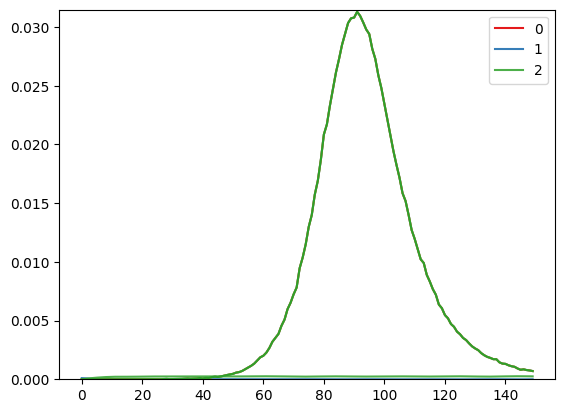

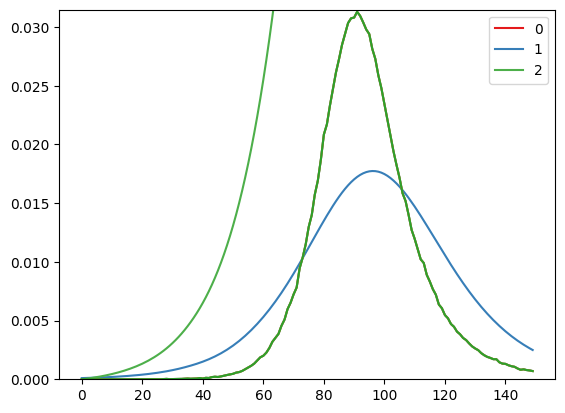

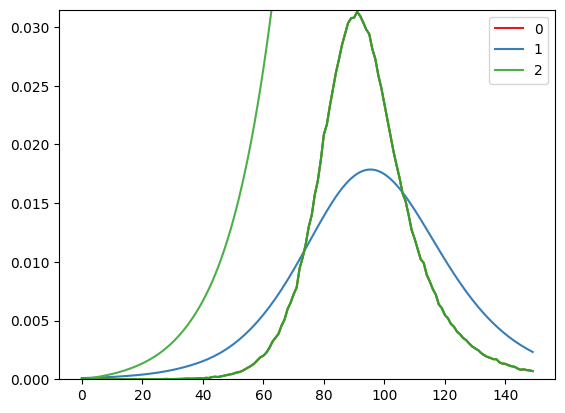

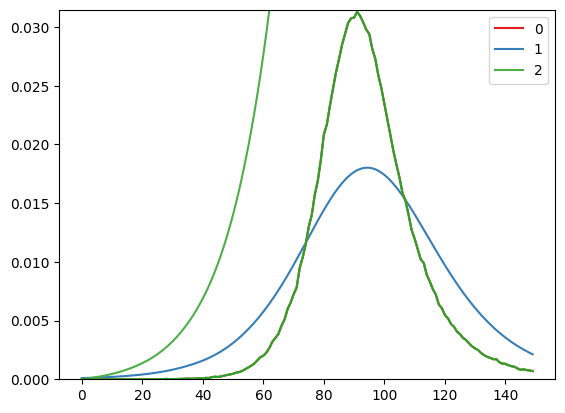

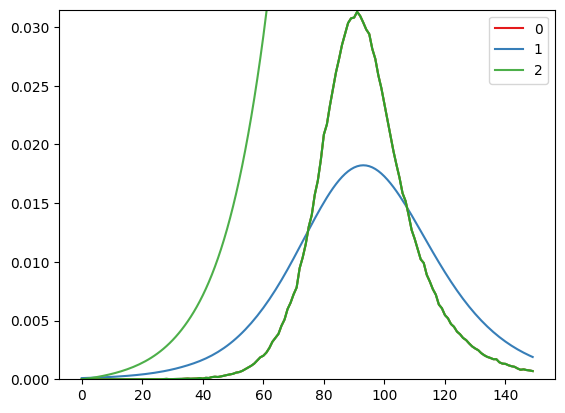

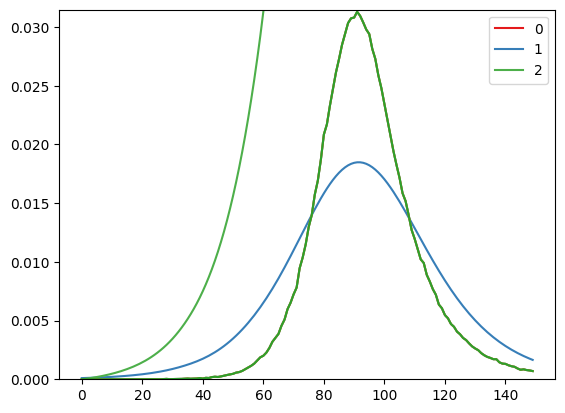

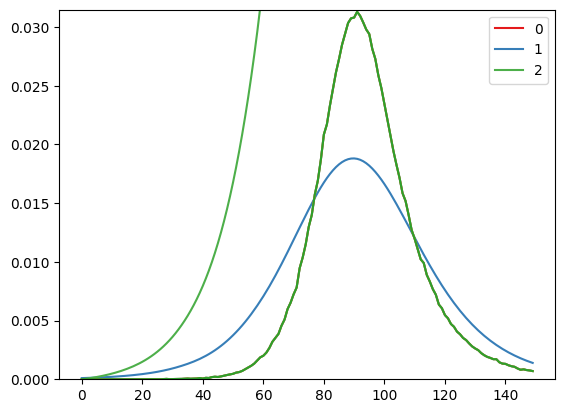

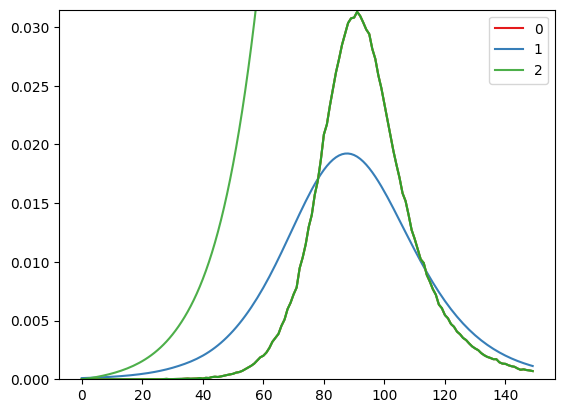

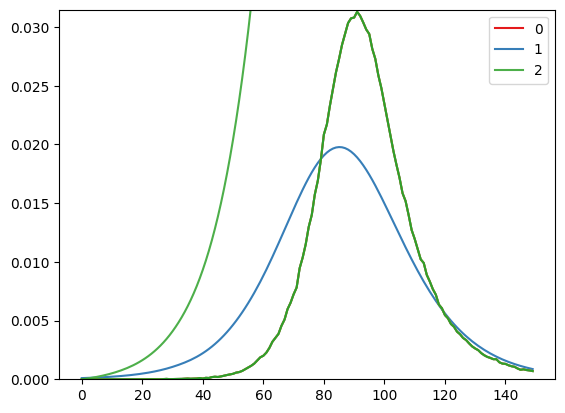

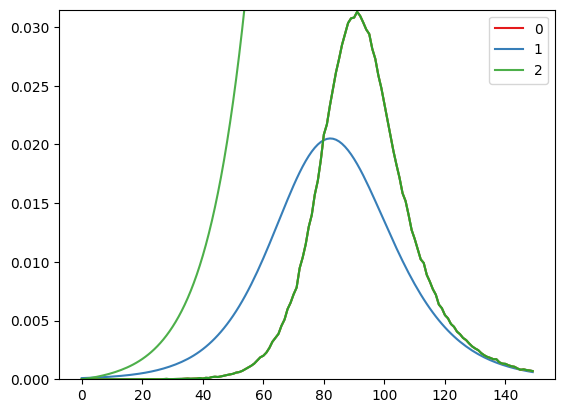

In [69]:
import torch
from torchdiffeq import odeint
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import normalize

colors = sns.color_palette('Set1')

cities_count = 5
big_size = 660000
small_size = 110000
flow_to_msk = 0.15
flow_to_obl = 0.03/4
flow_to_neighbour = 0.01
flow_to_corner = 0.002

flow_red = 0.1

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
adjacency_matrix = flow_red * np.array([[0, flow_to_obl, flow_to_obl, flow_to_obl, flow_to_obl],
                            [flow_to_msk, 0, flow_to_neighbour, flow_to_neighbour, flow_to_corner],
                            [flow_to_msk, flow_to_neighbour, 0, flow_to_corner, flow_to_neighbour],
                            [flow_to_msk, flow_to_neighbour, flow_to_corner, 0, flow_to_neighbour],
                            [flow_to_msk, flow_to_corner, flow_to_neighbour, flow_to_neighbour, 0]])


dt = np.load(f'pkls/diffsatellites_1_1.0_{flow_red}.npy', allow_pickle=True)[0,:,0,1:]
dt = (dt.T/pop_sizes).T



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sir(t, y, params):
    S = y[0]
    I = y[1]
    R = y[2]
    beta = params[0]
    g = params[1]
    dS = - beta * S * I
    dI = beta * S * I - g * I
    dR = g * I
    
    return torch.stack([dS, dI, dR])


def solve_ode(params, t, y):
    def ode_func(t, y):
        return sir(t, y, params)
    return odeint(ode_func, y0, t, method='dopri5', atol=1e-5, rtol=1e-5)


cities_count = 1
city_ind = 0

# print(dt[0].shape)

t = torch.arange(dt.shape[-1], device=device).float()
y0 = torch.from_numpy(np.array([[0.9999]*cities_count, [0.0001]*cities_count, [0]*cities_count])).to(device).float()
true_y = torch.from_numpy(dt[city_ind]).to(device).float()

# print(y0)

params = torch.rand(2, 1, device=device, requires_grad=True).float()
t_c = torch.rand(cities_count, device=device, requires_grad=True).float()
jump_size = torch.rand(cities_count, device=device, requires_grad=True).float()

# print(t_c, jump_size)

optimizer = optim.Adam([params, t_c, jump_size], lr=1e-2)
# warmup_steps = 1000
# optimizer = torch.optim.AdamW([params, t_c, jump_size], lr=0.1, weight_decay=0.01)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda step: min(1.0, step / warmup_steps))

# optimizer = torch.optim.AdamW([params, t_c, jump_size], lr=0.001)
# scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=0.1, step_size_up=500, mode='triangular')

n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad() 
    
    y_pred = solve_ode(params, t, y0)

    loss = torch.mean((torch.roll(y_pred[:,1,city_ind], shifts=int(100 * t_c)) - true_y) ** 2) + torch.mean((torch.sum(y_pred[:,1,city_ind], dim=0) - torch.sum(true_y, dim=0)) ** 2) / true_y.shape[0] #+ torch.sigmoid(params[1] - params[0])
    
    loss.backward()
    
    optimizer.step()

    # scheduler.step()

    with torch.no_grad():
        t_c.clamp_(min=0.0, max=dt.shape[-1])
        # params.clamp_(min=0.0, max=1e-3)
        params.clamp_min_(min=0.0)
        # jump_size.clamp_(min=0.0, max=np.max(dt))
        jump_size.clamp_min_(min=0.0)
        y0.data = normalize(y0.data, dim=0, p=1.0)

        
    
    if epoch % 100 == 0:
        y_pred_npy = y_pred.detach().cpu().numpy()
        fig, ax = plt.subplots()
        for i in range(y_pred_npy.shape[1]):
            # print(y_pred_npy.shape)
            ax.plot(y_pred_npy[:,i,:], color=colors[i], label=i)
            ax.plot(dt[city_ind])
            # ax.plot()
            # ax.set_xlim(0,20)
            ax.set_ylim(0,np.max(dt))
        ax.legend()

        print(f'Epoch {epoch}, -log10(Loss): {-np.log10(loss.item()):.4f}, Params: {params.detach().cpu().numpy()}, '
              f't_c: {t_c.detach().cpu().numpy()}, Jump size: {jump_size.detach().cpu().numpy()}')


print(f'Оптимизированные параметры: {params.detach().cpu().numpy()}')
print(f'Оптимизированный t_c: {t_c.detach().cpu().numpy()}')
print(f'Оптимизированная величина поступления: {jump_size.detach().cpu().numpy()}')

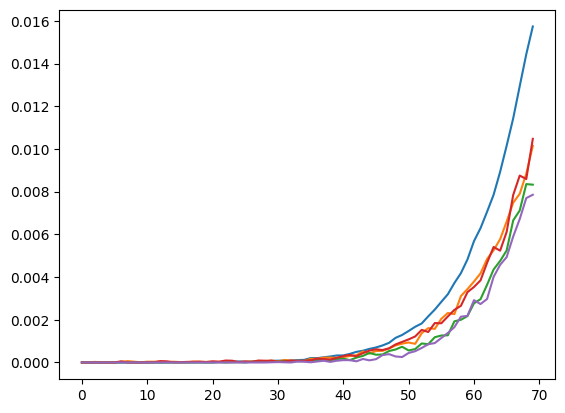

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

cities_count = 5
big_size = 660000
small_size = 110000
flow_to_msk = 0.15
flow_to_obl = 0.03/4
flow_to_neighbour = 0.01
flow_to_corner = 0.002

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
adjacency_matrix = np.array([[0, flow_to_obl, flow_to_obl, flow_to_obl, flow_to_obl],
                            [flow_to_msk, 0, flow_to_neighbour, flow_to_neighbour, flow_to_corner],
                            [flow_to_msk, flow_to_neighbour, 0, flow_to_corner, flow_to_neighbour],
                            [flow_to_msk, flow_to_neighbour, flow_to_corner, 0, flow_to_neighbour],
                            [flow_to_msk, flow_to_corner, flow_to_neighbour, flow_to_neighbour, 0]])

dt = np.load('pkls/diffsatellites_1_1.0_1.0.npy', allow_pickle=True)[0,:,0,1:]
dt = (dt.T/pop_sizes)

plt.plot(dt[:70,:])
# print(dt)

In [80]:
dt.shape
dt[:,0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.06060606e-06, 1.51515152e-06, 0.00000000e+00, 4.54545455e-06,
       4.54545455e-06, 4.54545455e-06, 1.51515152e-06, 1.21212121e-05,
       1.51515152e-06, 9.09090909e-06, 1.51515152e-05, 1.51515152e-05,
       6.06060606e-06, 1.36363636e-05, 1.96969697e-05, 1.21212121e-05,
       1.36363636e-05, 1.81818182e-05, 2.57575758e-05, 3.18181818e-05,
       4.84848485e-05, 3.78787879e-05, 3.18181818e-05, 5.45454545e-05,
       5.00000000e-05, 7.72727273e-05, 8.33333333e-05, 8.78787879e-05,
       8.93939394e-05, 1.13636364e-04, 1.21212121e-04, 2.06060606e-04,
       2.03030303e-04, 2.42424242e-04, 2.80303030e-04, 3.27272727e-04,
       3.30303030e-04, 4.01515152e-04, 4.96969697e-04, 5.50000000e-04,
       6.36363636e-04, 7.03030303e-04, 7.96969697e-04, 9.19696970e-04,
       1.15303030e-03, 1.28787879e-03, 1.47575758e-03, 1.67121212e-03,
       1.82727273e-03, 2.16060606e-03, 2.47575758e-03, 2.83939394e-03,
      

(0.0, 0.2)

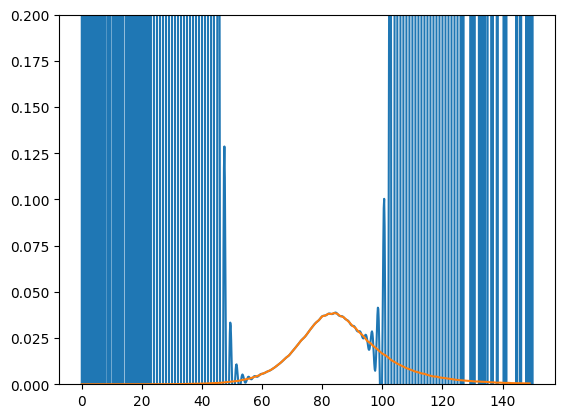

In [85]:
import scipy.interpolate as spi


f = spi.BarycentricInterpolator(np.arange(dt.shape[0]), dt[:,0])

t = np.linspace(0,dt.shape[0],1000)

plt.plot(t,f(t))
plt.plot(dt[:,0])
plt.ylim(0,0.2)

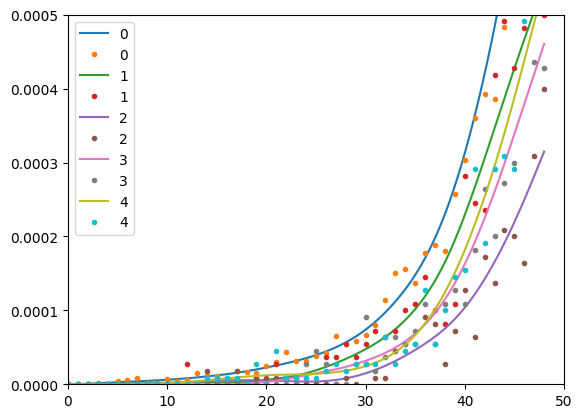

In [183]:
import scipy.interpolate as spi
import scipy
import scipy.ndimage

end_day = 50

dt = np.load('pkls/diffsatellites_0_1.0_1.0.npy', allow_pickle=True)[0,:,0,1:end_day]
dt = (dt.T/pop_sizes)

for i in range(dt.shape[-1]):
    f = spi.make_smoothing_spline(np.arange(dt.shape[0]), dt[:,i], lam=100)
    t = np.linspace(0,dt.shape[0]-1,1000)

    plt.plot(t,f(t), label=i)
    plt.plot(dt[:,i], '.', label=i)

plt.legend()
plt.ylim(0,0.0005)
plt.xlim(0,50)
plt.savefig(f'graphs/odedetection_smoothing_example.png', dpi=600)
plt.show()

-3.0
1.0
0.0
0.5


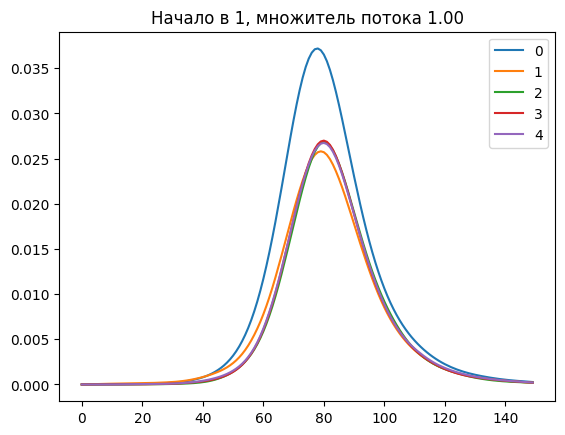

In [210]:
import scipy.interpolate as spi
import scipy
import scipy.ndimage
from dtw import *

end_day = 500

start_city = 1
# exp = 0.31622776601683794
exp = 1.0

# dt = np.load('pkls/diffsatellites_0_1.0_0.31622776601683794.npy', allow_pickle=True)[0,:,0,1:end_day]
dt = np.load(f'pkls/diffsatellites_{start_city}_1.0_{exp}.npy', allow_pickle=True)[2,:,0,1:end_day]
dt = (dt.T/pop_sizes)

for i in range(dt.shape[-1]):
    f = spi.make_smoothing_spline(np.arange(dt.shape[0]), dt[:,i], lam=100)
    t = np.linspace(0,dt.shape[0]-1,1000)

    dt[:,i] = f(np.arange(dt.shape[0]))

for i, row in enumerate(dt.T):
    plt.plot(row, label=i)
plt.legend()
plt.title(f'Начало в {start_city}, множитель потока {exp:.2f}')
# plt.savefig(f'graphs/odedetection_smooth_curves_{start_city}_{exp:.2f}.png', dpi=600)

for i in range(1, dt.shape[-1]):
    alignment = dtw(dt[:,i], dt[:,0], keep_internals=True)

    # alignment.plot(type="twoway")
    # plt.hist((alignment.index1-alignment.index2))
    print(np.median(alignment.index1-alignment.index2))



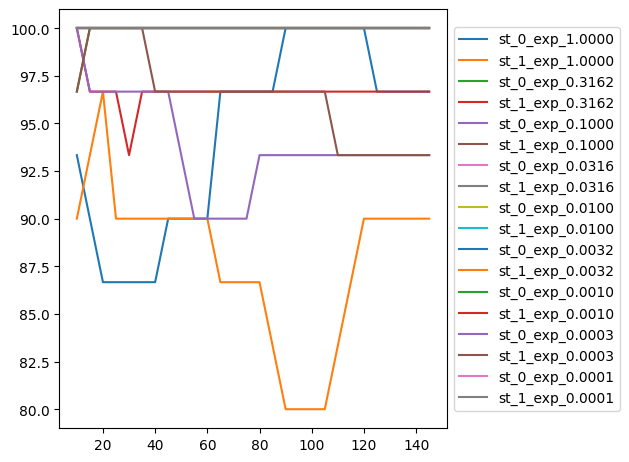

In [214]:
import scipy.interpolate as spi
import scipy
import scipy.ndimage
from dtw import *

end_day = 30

start_city = 0
exp = 0.31622776601683794
# exp = 1.0

end_day_list = range(10, 150, 5)

# dt = np.load('pkls/diffsatellites_0_1.0_0.31622776601683794.npy', allow_pickle=True)[0,:,0,1:end_day]
for exp in np.logspace(0,-4,9):
    for start_city in [0, 1]:
        accuracy = []
        for end_day in end_day_list:
            samples = np.load(f'pkls/diffsatellites_{start_city}_1.0_{exp}.npy', allow_pickle=True)[:,:,0,1:end_day]
            correct_count = 0

            for dt in samples:
                dt = (dt.T/pop_sizes)

                for i in range(dt.shape[-1]):
                    f = spi.make_smoothing_spline(np.arange(dt.shape[0]), dt[:,i], lam=100)
                    t = np.linspace(0,dt.shape[0]-1,1000)

                    dt[:,i] = f(np.arange(dt.shape[0]))

                shifts = []

                for i in range(1, dt.shape[-1]):
                    alignment = dtw(dt[:,i], dt[:,0], keep_internals=True)
                    shifts.append(np.mean(alignment.index1-alignment.index2))

                if np.all(np.array(shifts) > 0):
                    if start_city == 0:
                        correct_count += 1
                else:
                    if start_city == np.argmin(shifts)+1:
                        correct_count += 1
            
            accuracy.append(100*correct_count/samples.shape[0])
            # print(f'start_{start_city}_flowexp_{exp:.4f}_correct_{100*correct_count/samples.shape[0]:.1f}%')
        
        plt.plot(end_day_list, accuracy, label=f'st_{start_city}_exp_{exp:.4f}')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig(f'graphs/odedetection_accuracies.png', dpi=600)

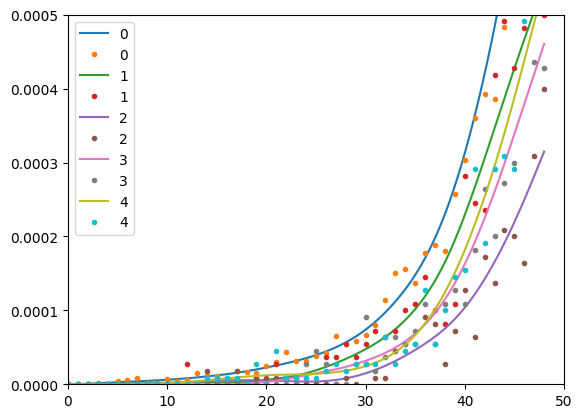

In [4]:
import scipy.interpolate as spi
import scipy
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt

end_day = 50

big_size = 660000
small_size = 110000

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
dt = np.load('pkls/diffsatellites_0_1.0_1.0.npy', allow_pickle=True)[0,:,0,1:end_day]
dt = (dt.T/pop_sizes)

for i in range(dt.shape[-1]):
    f = spi.make_smoothing_spline(np.arange(dt.shape[0]), dt[:,i], lam=100)
    t = np.linspace(0,dt.shape[0]-1,1000)

    plt.plot(t,f(t), label=i)
    plt.plot(dt[:,i], '.', label=i)

plt.legend()
plt.ylim(0,0.0005)
plt.xlim(0,50)
plt.savefig(f'graphs/odedetection_smoothing_example.png', dpi=600)
plt.show()

[66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000
 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000
 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000
 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000 66000
 66000] [ 0  0  0  0  0  0  0  1  0  0  0  2  1  0  0  0  0  1  1  0  2  1  2  1
  2  4  1  4  4  1  5  3  4 15 16 12 10  8 13 16 15 24 17 32 31 44 45 69
 71]


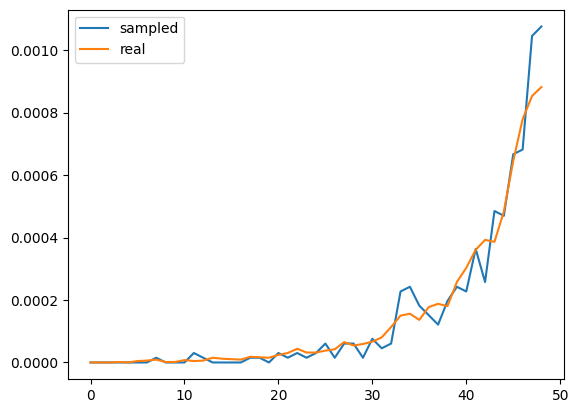

In [63]:
big_size = 660000
small_size = 110000

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
dt = np.load('pkls/diffsatellites_0_1.0_1.0.npy', allow_pickle=True)[0,:,0,1:end_day]
dt = (dt.T/pop_sizes)

i = 0

proportions = dt[:,i]

np.random.seed(42)  # Для воспроизводимости
n_total = pop_sizes[i]  # Общее количество объектов в каждом интервале
# proportions = np.array([0.1, 0.2, 0.3, 0.4, 0.5])  # Доли целевого класса
n_intervals = len(proportions)  # Количество временных интервалов
testing_ratio = 0.1  # Доля выборки (20%)

# Размер выборки для каждого интервала (можно варьировать для большего разброса)
n_samples = np.full(n_intervals, int(n_total * testing_ratio))

# Эмуляция выборки: количество объектов целевого класса в выборке
n_target = np.random.binomial(n_samples, proportions)

print(n_samples, n_target)

# Расчет доли целевого класса в выборке
sampled_proportions = n_target / n_samples

sampled_proportions

plt.plot(sampled_proportions, label='sampled')
plt.plot(proportions, label='real')
plt.legend()

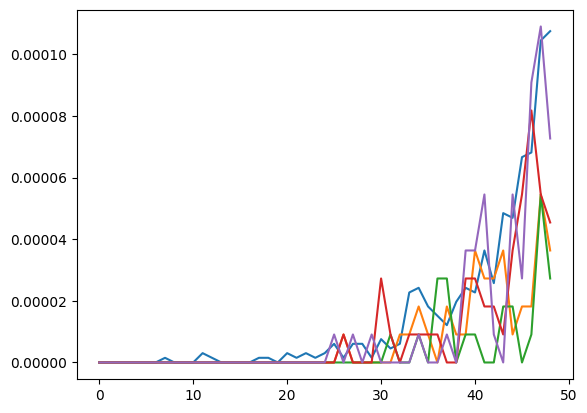

In [64]:

np.random.seed(42)
cities_count = 5
end_day = 50
big_size = 660000
small_size = 110000

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
dt = np.load('pkls/diffsatellites_0_1.0_1.0.npy', allow_pickle=True)[0,:,0,1:end_day]
dt = (dt.T/pop_sizes)

n_samples = np.ones((cities_count, n_intervals))
n_samples = (n_samples.T * pop_sizes).T * testing_ratio
n_target = np.random.binomial(n_samples.astype(int), dt.T)
tested_infected = (n_target.T / pop_sizes).T

# tested_infected

plt.plot(tested_infected.T, label='tested')


(5, 49)


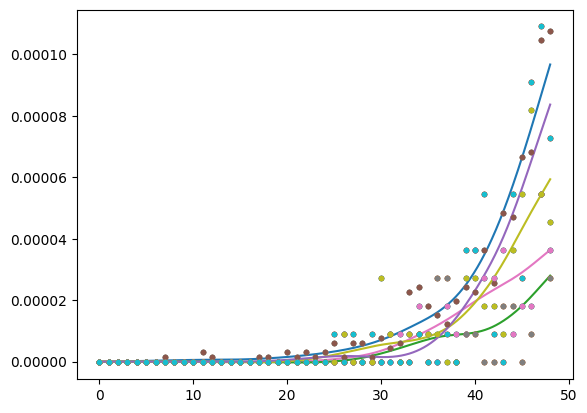

In [65]:
print(tested_infected.shape)
for i in range(tested_infected.shape[0]):
    f = spi.make_smoothing_spline(np.arange(tested_infected.shape[1]), tested_infected[i,:], lam=100)
    t = np.linspace(0,tested_infected.shape[-1]-1,1000)

    plt.plot(t,f(t), label=i)
    plt.plot(tested_infected.T, '.', label=i)

0 101.97731069699299
1 137.31336849550564
2 114.06511997769832
3 112.03423001873321
4 95.15143994192985


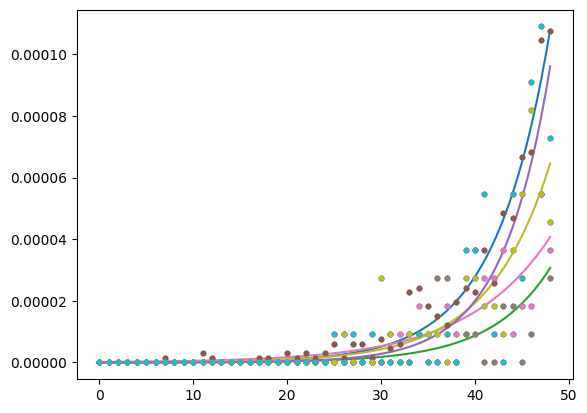

In [66]:
from scipy.optimize import curve_fit

def exp_func(x, a, b):
    return np.exp(a * (x - b))







for i in range(tested_infected.shape[0]):
    popt, pcov = curve_fit(exp_func, np.arange(tested_infected.shape[1]), tested_infected[i,:], p0=[1, 1]) 
    x_fit = np.linspace(min(np.arange(tested_infected.shape[1])), max(np.arange(tested_infected.shape[1])), 100)
    y_fit = exp_func(x_fit, *popt)
    print(i, popt[-1])

    # f = spi.make_smoothing_spline(np.arange(tested_infected.shape[1]), tested_infected[i,:], lam=100)
    # t = np.linspace(0,tested_infected.shape[-1]-1,1000)

    # plt.plot(t,f(t), label=i)
    plt.plot(x_fit, y_fit)
    plt.plot(tested_infected.T, '.', label=i)

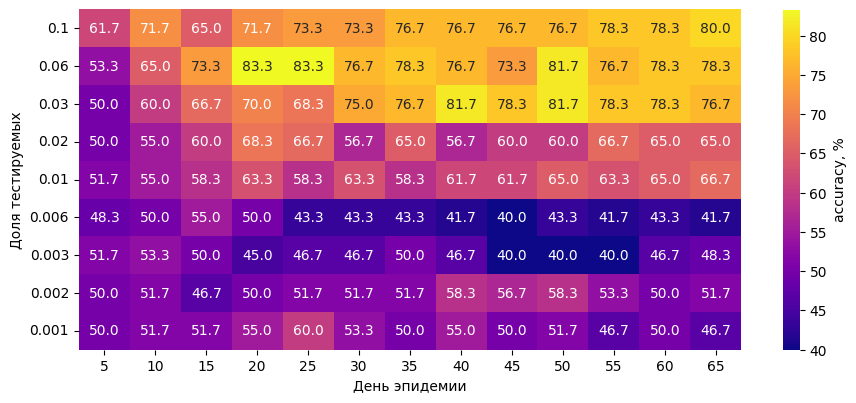

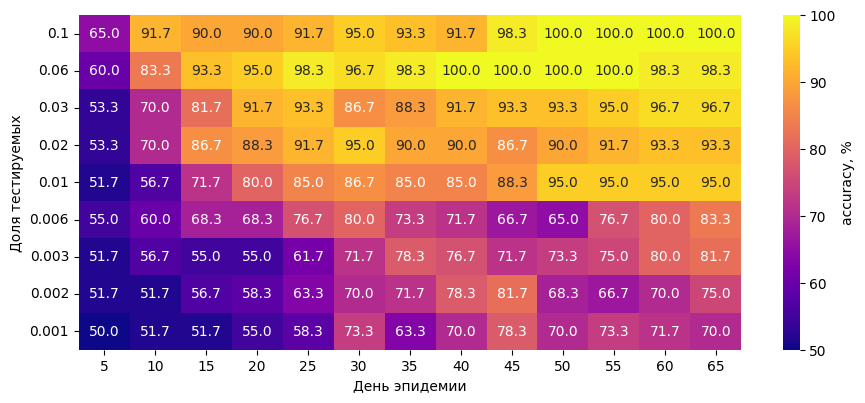

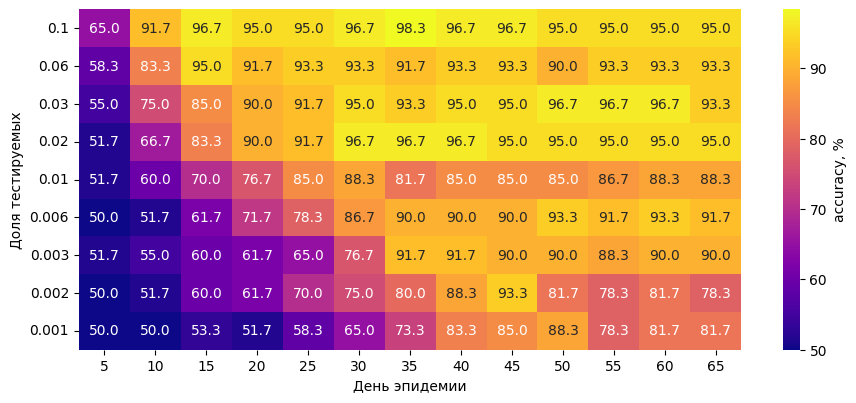

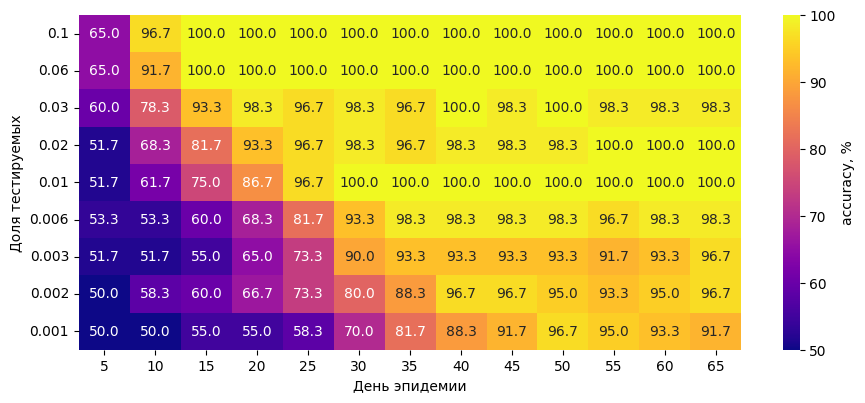

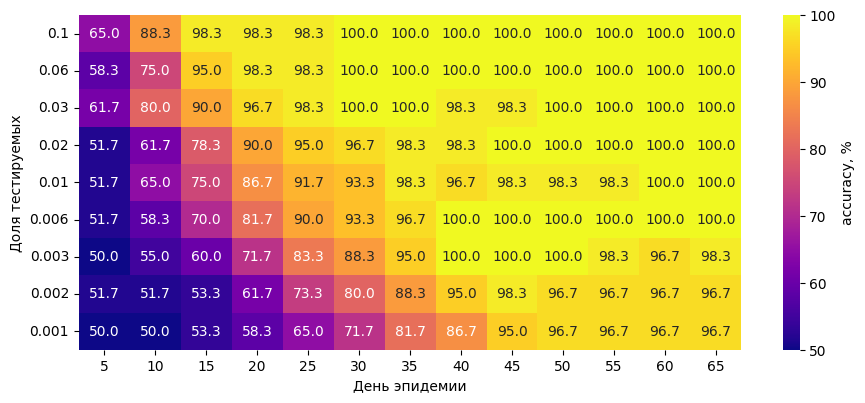

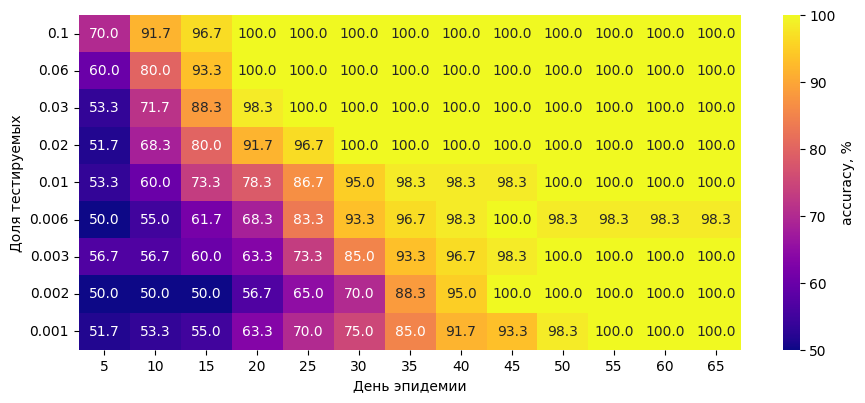

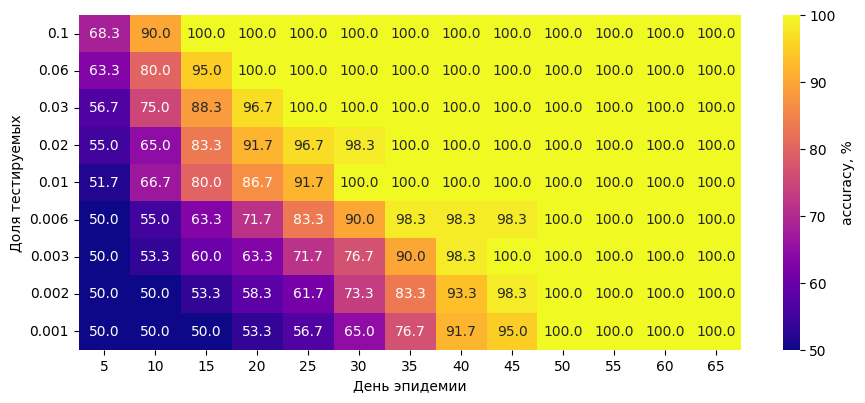

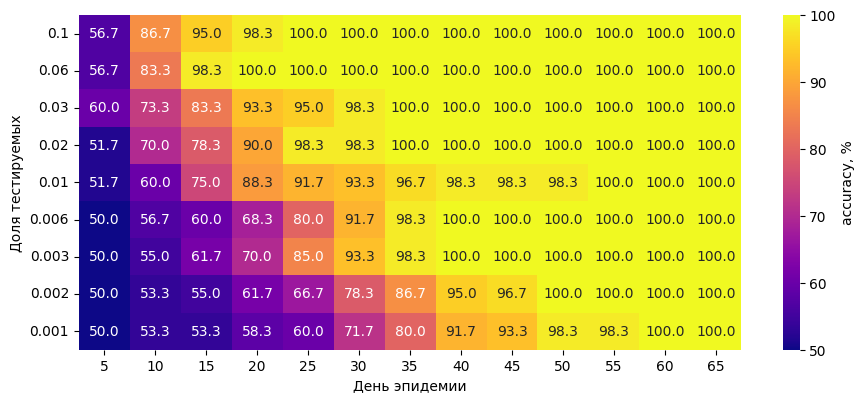

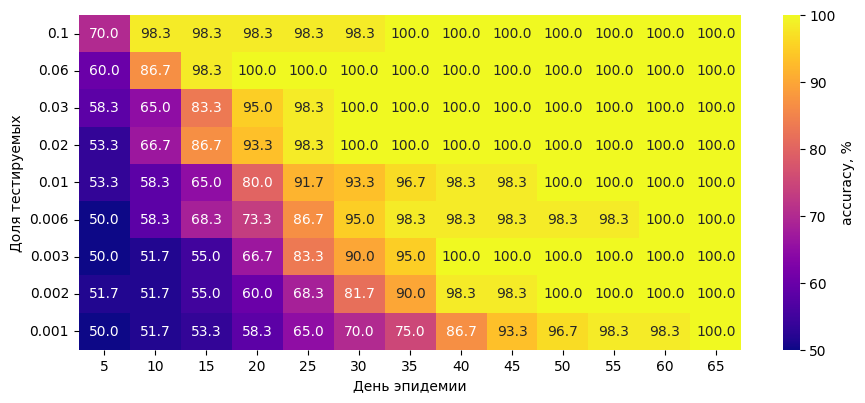

In [5]:
from dtw import *
import scipy.interpolate as spi
import scipy
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import seaborn as sns

def round_to_first_significant(x):
    if x == 0:
        return 0
    return round(x, -int(math.floor(math.log10(abs(x)))))

np.random.seed(42)
cities_count = 5
big_size = 660000
small_size = 110000

start_city = 0

pop_sizes = np.array([big_size, small_size, small_size, small_size, small_size])
dt = np.load(f'pkls/diffsatellites_{start_city}_1.0_1.0.npy', allow_pickle=True)[0,:,0,:]
dt = (dt.T/pop_sizes)
dt[0,:] = 0

def exp_func(x, a, b):
    return np.exp(a * (x - b))

n_intervals = dt.shape[0]

test_dim = 9
time_dim = 13

for flow in np.logspace(0,-4,9):
    correct_count = np.zeros((test_dim, time_dim))

    for start_city in [0, 1]:
        data = np.load(f'pkls/diffsatellites_{start_city}_1.0_{flow}.npy', allow_pickle=True)[:,:,0,:]
        for dt in data:
            dt = (dt.T/pop_sizes)
            dt[0,:] = 0

            n_intervals = dt.shape[0]
            
            for ii, testing_ratio in enumerate(np.logspace(-3,-1,test_dim)):
                n_samples = np.ones((cities_count, n_intervals))
                n_samples = (n_samples.T * pop_sizes).T * testing_ratio
                n_target = np.random.binomial(n_samples.astype(int), dt.T)
                tested_infected = (n_target.T / pop_sizes).T

                for jj, end_day in enumerate(range(5,70,5)):
                    tested_sample = tested_infected[:,:end_day]
                    # print(tested_sample)

                    fits = []
                    for i in range(tested_sample.shape[0]):
                        try:
                            popt, pcov = curve_fit(exp_func, np.arange(tested_sample.shape[1]), tested_sample[i,:], p0=[1, 1]) 
                            x_fit = np.linspace(min(np.arange(tested_sample.shape[1])), max(np.arange(tested_sample.shape[1])), 100)
                            y_fit = exp_func(x_fit, *popt)
                            fits.append(y_fit)
                            pass
                        except:
                            x_fit = np.linspace(min(np.arange(tested_sample.shape[1])), max(np.arange(tested_sample.shape[1])), 100)
                            y_fit = exp_func(x_fit, *[0, 0])
                            fits.append(y_fit)
                            pass
                    
                    fits = np.array(fits)

                    shifts = []

                    for i in range(1, tested_sample.shape[0]):
                        alignment = dtw(tested_sample[i,:], tested_sample[0,:], keep_internals=True)
                        shifts.append(np.mean(alignment.index1-alignment.index2))

                    if np.all(np.array(shifts) > 0):
                        if start_city == 0:
                            correct_count[ii,jj] += 1
                    else:
                        if start_city == np.argmin(shifts)+1:
                            correct_count[ii,jj] += 1

    correct_count = 100*correct_count/60

    A4_WIDTH = 1+8.27  # Ширина A4
    A4_HEIGHT = 8.27/2  # Высота A4 (можно уменьшить, если нужно)
    fig, ax = plt.subplots(1, 1, figsize=(A4_WIDTH, A4_HEIGHT))

    sns.heatmap(correct_count[::-1,:], annot=True, fmt=".1f", xticklabels=[day for day in range(5,70,5)], yticklabels=[round_to_first_significant(y) for y in np.logspace(-3,-1,test_dim)[::-1]],
                cmap="plasma", cbar_kws={'label': r'accuracy, %'}, ax=ax)

    ax.set_xlabel("День эпидемии")
    ax.set_ylabel("Доля тестируемых")
    # ax[1].set_title("t-статистики дня пика")

    plt.subplots_adjust(wspace=1, hspace=0)
    plt.tight_layout()
    plt.savefig(f'graphs/odedetection_heatmap_detection_flows_{flow}.png', dpi=600)
    plt.savefig(f'graphs/odedetection_heatmap_detection_flows_{flow}.pdf')
        

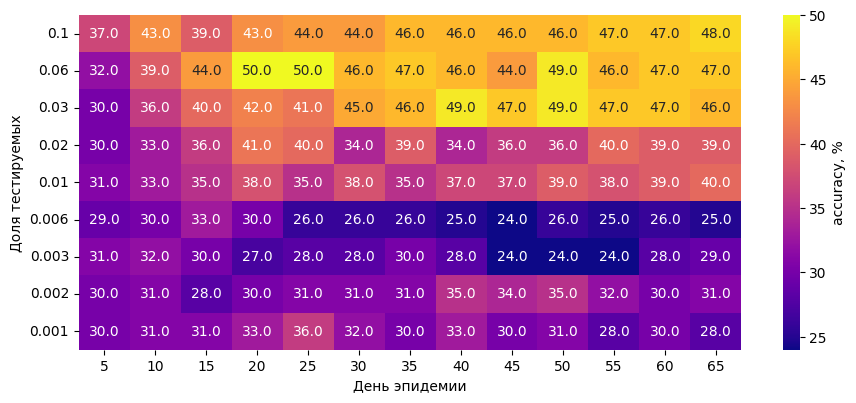

In [ ]:
import math
import seaborn as sns

flow = 1.0



